In [1]:
# -*- coding: utf-8 -*-
# Author : Ali Mirzaei
# Date : 19/09/2017


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Dropout, Flatten, Activation,Concatenate,LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend, models
#import tensorflow_addons as tfa
import tensorflow as tf
import helpers

print(tf.__version__)
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# need to add these for the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# import the image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


2.1.0


In [2]:
#Setting the parameters for training

# batch size and image width to use
batch_size=128
width=100

# all the data directories
train_dir='train/';
test_dir='test/'
valid_dir='valid/';

# the number of epochs
num_epochs=5000

# creating an image generator that will feed the data from
# each of the directories

# we use scaling transformation in this generator
generator=ImageDataGenerator(rescale=1./255)

# we specify the size of the input and batch size
# size of the input is necessary because the image
# needs to be rescaled for the neural network

train_data=generator.flow_from_directory(train_dir, target_size=(width,width),batch_size=10000)
valid_data=generator.flow_from_directory(valid_dir, target_size=(width,width),batch_size=1000)
test_data=generator.flow_from_directory(test_dir, target_size=(width,width),batch_size=1000)

# the number of steps per epoch is samples/batch size
# we need to use these numbers later

train_steps_per_epoch=math.ceil(train_data.samples/batch_size)
valid_steps_per_epoch=math.ceil(valid_data.samples/batch_size)
test_steps_per_epoch=math.ceil(test_data.samples/batch_size)

x_train, y_train = train_data.next()
x_test, y_test = test_data.next()
x_train.shape
num_labels = len(train_data.class_indices)

import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


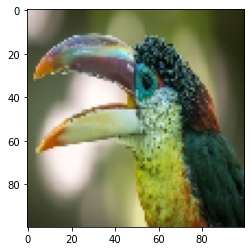

In [3]:
show_image(x_train[1])


In [4]:
img_rows = width
img_cols = width
channels = 3

# network parameters
input_shape = (img_rows, img_cols, channels)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 256


In [5]:
matplotlib.use('Agg')

import matplotlib.pyplot as plt

plt.ioff()

initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
from keras import backend as K

epochs=5000

img_rows = width
img_cols = width
channels = 3

# network parameters
input_shape = (img_rows, img_cols, channels)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [16, 32]

class AAN:
    def __init__(self, img_shape=input_shape, encoded_dim=latent_dim):
        self.encoded_dim = encoded_dim
        self.optimizer_reconst = Adam(0.01)
        self.optimizer_discriminator = Adam(0.01)
        self._initAndCompileFullModel(img_shape, encoded_dim)

    def _genEncoderModel(self, img_shape, encoded_dim):
        """ Build Encoder Model Based on Paper Configuration
        Args:
            img_shape (tuple) : shape of input image
            encoded_dim (int) : number of latent variables
        Return:
            A sequential keras model
        """
        input_shape = img_shape
        latent_dim = encoded_dim

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        # stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        # shape info needed to build decoder model so we don't do hand computation
        # the input to the decoder's first Conv2DTranspose will have this shape
        # shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
        self.shape = K.int_shape(x)

        # generate a latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        # instantiate encoder model
        encoder = Model(inputs, latent, name='encoder')
        encoder.summary()
        return encoder

    def _getDecoderModel(self, encoded_dim, img_shape):
        """ Build Decoder Model Based on Paper Configuration
        Args:
            encoded_dim (int) : number of latent variables
            img_shape (tuple) : shape of target images
        Return:
            A sequential keras model
        """
        latent_dim = encoded_dim
        shape = self.shape

        # build the decoder model
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)

        outputs = Conv2DTranspose(filters=channels,
                                  kernel_size=kernel_size,
                                  activation='sigmoid',
                                  padding='same',
                                  name='decoder_output')(x)

        # instantiate decoder model
        decoder = Model(latent_inputs, outputs, name='decoder')
        decoder.summary()

        return decoder

    def _getDescriminator(self, encoded_dim):
        """ Build Descriminator Model Based on Paper Configuration
        Args:
            encoded_dim (int) : number of latent variables
        Return:
            A sequential keras model
        """

        input_shape = encoded_dim
        shape = self.shape

        # build the decoder model
        latent_inputs = Input(shape=(latent_dim,), name='discriminator_input')
        x = Dense(shape[1]*shape[2]*shape[3], kernel_initializer=initializer,
                          bias_initializer=initializer)(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of BN-ReLU-Transposed Conv2D-UpSampling blocks
        for filters in layer_filters[::-1]:
            #x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                padding='same', kernel_initializer=initializer,
                          bias_initializer=initializer)(x)
            x = UpSampling2D()(x)

        x = Flatten()(x)
        outputs = Dense(1, name='discriminator_output', activation='sigmoid',
                        kernel_initializer=initializer, bias_initializer=initializer)(x)

        # instantiate discriminator model
        discriminator = Model(latent_inputs, outputs, name='discriminator')
        discriminator.summary()

        return discriminator

    def _initAndCompileFullModel(self, img_shape, encoded_dim):
        self.encoder = self._genEncoderModel(img_shape, encoded_dim)
        self.decoder = self._getDecoderModel(encoded_dim, img_shape)
        self.discriminator = self._getDescriminator(encoded_dim)
        img = Input(shape=img_shape)
        encoded_repr = self.encoder(img)
        gen_img = self.decoder(encoded_repr)
        self.autoencoder = Model(img, gen_img)
        valid = self.discriminator(encoded_repr)
        self.encoder_discriminator = Model(img, valid)
        self.discriminator.compile(optimizer=self.optimizer_discriminator,
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])
        self.autoencoder.compile(optimizer=self.optimizer_reconst,
                                 loss='mse')
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.encoder_discriminator.compile(optimizer=self.optimizer_discriminator,
                                           loss='binary_crossentropy',
                                           metrics=['accuracy'])

    def imagegrid(self, epochnumber):
        fig = plt.figure(figsize=[20, 20])
        images = self.generateImages(100)
        for index, img in enumerate(images):
            img = img.reshape(input_shape)
            ax = fig.add_subplot(10, 10, index + 1)
            ax.set_axis_off()
            ax.imshow(img, cmap="gray")
        fig.savefig("images/AAE/" + str(epochnumber) + ".png")
        plt.show()
        plt.close(fig)

    def generateImages(self, n=100):
        latents = 5 * np.random.normal(size=(n, self.encoded_dim))
        imgs = self.decoder.predict(latents)
        return imgs

    def train(self, x_train, batch_size=100, epochs=5000, save_interval=500):
        half_batch = int(batch_size / 2)
        for epoch in range(epochs):
            # ---------------Train Discriminator -------------
            # Select a random half batch of images
            idx = np.random.randint(0, x_train.shape[0], half_batch)
            imgs = x_train[idx]
            # Generate a half batch of new images
            latent_fake = self.encoder.predict(imgs)
            # gen_imgs = self.decoder.predict(latent_fake)
            latent_real = 5 * np.random.normal(size=(half_batch, self.encoded_dim))
            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]
            # Generator wants the discriminator to label the generated representations as valid
            valid_y = np.ones((batch_size, 1))

            # Train the autoencode reconstruction
            g_loss_reconstruction = self.autoencoder.train_on_batch(imgs, imgs)

            # Train generator
            g_logg_similarity = self.encoder_discriminator.train_on_batch(imgs, valid_y)
            # Plot the progress
            print("%d [D loss: %f, acc: %.2f%%] [G acc: %f, mse: %f]" % (epoch, d_loss[0], 100 * d_loss[1],
                                                                         g_logg_similarity[1], g_loss_reconstruction))
            if (epoch % save_interval == 0):
                self.imagegrid(epoch)

In [ ]:
ann = AAN(encoded_dim=latent_dim)
ann.train(x_train, batch_size, num_epochs, 500)
generated = ann.generateImages(10000)
L = helpers.approximateLogLiklihood(generated, x_test)
print("Log Likelihood")
print(L)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               5120256   
Total params: 5,125,344
Trainable params: 5,125,344
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Out

63 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056461]
64 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055617]
65 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055875]
66 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055706]
67 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058257]
68 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053025]
69 [D loss: 70.739037, acc: 50.00%] [G acc: 0.000000, mse: 0.058285]
70 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054359]
71 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057868]
72 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058527]
73 [D loss: 42.056084, acc: 92.97%] [G acc: 0.000000, mse: 0.054107]
74 [D loss: 40.425743, acc: 92.97%] [G acc: 0.000000, mse: 0.056673]
75 [D loss: 23.858910, acc: 96.88%] [G acc: 0.000000, mse: 0.061147]
76 [D loss: 12.081825, acc: 98.44%] [G acc: 0.000000, mse: 0.057134]
77 [D loss: 5.129197, acc: 98.44%]

181 [D loss: 8.438973, acc: 99.22%] [G acc: 0.000000, mse: 0.054925]
182 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055251]
183 [D loss: 1106.354736, acc: 50.00%] [G acc: 0.000000, mse: 0.055127]
184 [D loss: 44.492252, acc: 99.22%] [G acc: 0.000000, mse: 0.055825]
185 [D loss: 9.812072, acc: 99.22%] [G acc: 0.000000, mse: 0.059628]
186 [D loss: 175.370071, acc: 89.06%] [G acc: 0.000000, mse: 0.059100]
187 [D loss: 498.217438, acc: 77.34%] [G acc: 0.000000, mse: 0.058769]
188 [D loss: 30.789919, acc: 98.44%] [G acc: 0.000000, mse: 0.057226]
189 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057018]
190 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054328]
191 [D loss: 87.700493, acc: 98.44%] [G acc: 0.000000, mse: 0.057952]
192 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055675]
193 [D loss: 64.853828, acc: 99.22%] [G acc: 0.000000, mse: 0.060070]
194 [D loss: 39.645294, acc: 98.44%] [G acc: 0.000000, mse: 0.053835]
195 [D loss: 116.8

300 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060621]
301 [D loss: 232.129761, acc: 99.22%] [G acc: 0.000000, mse: 0.062220]
302 [D loss: 44.694614, acc: 99.22%] [G acc: 0.000000, mse: 0.058830]
303 [D loss: 760.457397, acc: 50.00%] [G acc: 0.000000, mse: 0.057240]
304 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058676]
305 [D loss: 73.389221, acc: 98.44%] [G acc: 0.000000, mse: 0.055605]
306 [D loss: 1865.687256, acc: 59.38%] [G acc: 0.000000, mse: 0.053503]
307 [D loss: 59.183262, acc: 99.22%] [G acc: 0.000000, mse: 0.056822]
308 [D loss: 283.504669, acc: 98.44%] [G acc: 0.000000, mse: 0.060579]
309 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059758]
310 [D loss: 220.192535, acc: 99.22%] [G acc: 0.000000, mse: 0.057275]
311 [D loss: 664.501099, acc: 98.44%] [G acc: 0.000000, mse: 0.054782]
312 [D loss: 361.239899, acc: 99.22%] [G acc: 0.000000, mse: 0.061245]
313 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056021]
314 [D loss:

417 [D loss: 108.641724, acc: 98.44%] [G acc: 0.000000, mse: 0.059046]
418 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060961]
419 [D loss: 112.064171, acc: 98.44%] [G acc: 0.000000, mse: 0.057967]
420 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060235]
421 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058617]
422 [D loss: 249.387283, acc: 99.22%] [G acc: 0.000000, mse: 0.054664]
423 [D loss: 120.893059, acc: 99.22%] [G acc: 0.000000, mse: 0.059226]
424 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059390]
425 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.051971]
426 [D loss: 79.164619, acc: 99.22%] [G acc: 0.000000, mse: 0.055612]
427 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058962]
428 [D loss: 59.611355, acc: 99.22%] [G acc: 0.000000, mse: 0.056784]
429 [D loss: 2.284552, acc: 99.22%] [G acc: 0.000000, mse: 0.056817]
430 [D loss: 6.928736, acc: 99.22%] [G acc: 0.000000, mse: 0.057355]
431 [D loss: 0.000

535 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057565]
536 [D loss: 434.557800, acc: 50.00%] [G acc: 0.000000, mse: 0.055803]
537 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055885]
538 [D loss: 238.442139, acc: 99.22%] [G acc: 0.000000, mse: 0.059516]
539 [D loss: 191.363464, acc: 98.44%] [G acc: 0.000000, mse: 0.056134]
540 [D loss: 766.099731, acc: 95.31%] [G acc: 0.000000, mse: 0.060835]
541 [D loss: 962.376892, acc: 94.53%] [G acc: 0.000000, mse: 0.056262]
542 [D loss: 1323.660156, acc: 92.19%] [G acc: 0.000000, mse: 0.059067]
543 [D loss: 831.463867, acc: 95.31%] [G acc: 0.000000, mse: 0.064048]
544 [D loss: 861.543579, acc: 93.75%] [G acc: 0.000000, mse: 0.053756]
545 [D loss: 391.078278, acc: 96.88%] [G acc: 0.000000, mse: 0.061557]
546 [D loss: 366.754150, acc: 96.88%] [G acc: 0.000000, mse: 0.056218]
547 [D loss: 341.482452, acc: 98.44%] [G acc: 0.000000, mse: 0.062035]
548 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055675]
549 [D l

653 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059670]
654 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058921]
655 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056316]
656 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058296]
657 [D loss: 2003.296997, acc: 50.00%] [G acc: 0.000000, mse: 0.059150]
658 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054715]
659 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056856]
660 [D loss: 318.616852, acc: 96.88%] [G acc: 0.000000, mse: 0.055626]
661 [D loss: 581.314392, acc: 92.97%] [G acc: 0.000000, mse: 0.056119]
662 [D loss: 525.778870, acc: 93.75%] [G acc: 0.000000, mse: 0.065102]
663 [D loss: 168.099152, acc: 96.88%] [G acc: 0.000000, mse: 0.056831]
664 [D loss: 189.165604, acc: 98.44%] [G acc: 0.000000, mse: 0.061568]
665 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056723]
666 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059140]
667 [D loss: 

771 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057283]
772 [D loss: 233.738388, acc: 98.44%] [G acc: 0.000000, mse: 0.059654]
773 [D loss: 175.353928, acc: 99.22%] [G acc: 0.000000, mse: 0.057013]
774 [D loss: 225.960495, acc: 99.22%] [G acc: 0.000000, mse: 0.058978]
775 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059617]
776 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054421]
777 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059927]
778 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054610]
779 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055804]
780 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063333]
781 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062203]
782 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060451]
783 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058463]
784 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058820]
785 [D loss: 2228

888 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055148]
889 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056807]
890 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054849]
891 [D loss: 1668.692749, acc: 99.22%] [G acc: 0.000000, mse: 0.055085]
892 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053968]
893 [D loss: 379.186279, acc: 99.22%] [G acc: 0.000000, mse: 0.057881]
894 [D loss: 12846.974609, acc: 50.00%] [G acc: 0.000000, mse: 0.061187]
895 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053203]
896 [D loss: 884.682312, acc: 99.22%] [G acc: 0.000000, mse: 0.057906]
897 [D loss: 1423.961060, acc: 97.66%] [G acc: 0.000000, mse: 0.055808]
898 [D loss: 431.856506, acc: 98.44%] [G acc: 0.000000, mse: 0.060774]
899 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057683]
900 [D loss: 2128.198242, acc: 96.88%] [G acc: 0.000000, mse: 0.051283]
901 [D loss: 3717.683350, acc: 98.44%] [G acc: 0.000000, mse: 0.058199]
902 [D

1005 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061031]
1006 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060267]
1007 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057011]
1008 [D loss: 3161.187988, acc: 50.00%] [G acc: 0.000000, mse: 0.056216]
1009 [D loss: 971.421753, acc: 99.22%] [G acc: 0.000000, mse: 0.066763]
1010 [D loss: 963.387268, acc: 99.22%] [G acc: 0.000000, mse: 0.059429]
1011 [D loss: 59.401897, acc: 99.22%] [G acc: 0.000000, mse: 0.055811]
1012 [D loss: 1086.114868, acc: 98.44%] [G acc: 0.000000, mse: 0.058117]
1013 [D loss: 1595.849609, acc: 96.88%] [G acc: 0.000000, mse: 0.061230]
1014 [D loss: 2727.924072, acc: 95.31%] [G acc: 0.000000, mse: 0.058586]
1015 [D loss: 2770.865967, acc: 95.31%] [G acc: 0.000000, mse: 0.061048]
1016 [D loss: 4806.521484, acc: 91.41%] [G acc: 0.000000, mse: 0.056611]
1017 [D loss: 1526.992554, acc: 96.09%] [G acc: 0.000000, mse: 0.054559]
1018 [D loss: 1680.960449, acc: 97.66%] [G acc: 0.000000, mse

1119 [D loss: 3303.257324, acc: 96.09%] [G acc: 0.000000, mse: 0.060191]
1120 [D loss: 2370.664551, acc: 95.31%] [G acc: 0.000000, mse: 0.057525]
1121 [D loss: 1892.928833, acc: 94.53%] [G acc: 0.000000, mse: 0.056671]
1122 [D loss: 1693.326904, acc: 95.31%] [G acc: 0.000000, mse: 0.053326]
1123 [D loss: 2580.232666, acc: 96.09%] [G acc: 0.000000, mse: 0.062215]
1124 [D loss: 1682.021729, acc: 96.88%] [G acc: 0.000000, mse: 0.060566]
1125 [D loss: 218.128021, acc: 99.22%] [G acc: 0.000000, mse: 0.056644]
1126 [D loss: 434.678314, acc: 99.22%] [G acc: 0.000000, mse: 0.062013]
1127 [D loss: 1783.246216, acc: 97.66%] [G acc: 0.000000, mse: 0.056139]
1128 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057902]
1129 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060108]
1130 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061350]
1131 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056411]
1132 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 

1235 [D loss: 6929.766602, acc: 98.44%] [G acc: 0.000000, mse: 0.054692]
1236 [D loss: 608.359192, acc: 99.22%] [G acc: 0.000000, mse: 0.060736]
1237 [D loss: 589.098328, acc: 99.22%] [G acc: 0.000000, mse: 0.059557]
1238 [D loss: 340.674011, acc: 99.22%] [G acc: 0.000000, mse: 0.059810]
1239 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054537]
1240 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056774]
1241 [D loss: 2832.941895, acc: 99.22%] [G acc: 0.000000, mse: 0.060191]
1242 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058650]
1243 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061984]
1244 [D loss: 4046.126465, acc: 98.44%] [G acc: 0.000000, mse: 0.054969]
1245 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057634]
1246 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058230]
1247 [D loss: 61596.292969, acc: 50.00%] [G acc: 0.000000, mse: 0.058549]
1248 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.05

1351 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057518]
1352 [D loss: 754.621948, acc: 99.22%] [G acc: 0.000000, mse: 0.055533]
1353 [D loss: 69.596382, acc: 99.22%] [G acc: 0.000000, mse: 0.055522]
1354 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062010]
1355 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058481]
1356 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058243]
1357 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055327]
1358 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059633]
1359 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060001]
1360 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056119]
1361 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062196]
1362 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059460]
1363 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057663]
1364 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057037]
1365 

1467 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061679]
1468 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055796]
1469 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053169]
1470 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054832]
1471 [D loss: 867.518188, acc: 50.00%] [G acc: 0.000000, mse: 0.058400]
1472 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055486]
1473 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061256]
1474 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055520]
1475 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.064259]
1476 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057082]
1477 [D loss: 33.040150, acc: 99.22%] [G acc: 0.000000, mse: 0.054769]
1478 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060180]
1479 [D loss: 569.566345, acc: 97.66%] [G acc: 0.000000, mse: 0.054954]
1480 [D loss: 2100.099121, acc: 99.22%] [G acc: 0.000000, mse: 0.055463]
14

1583 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058186]
1584 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062553]
1585 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055503]
1586 [D loss: 95.822060, acc: 99.22%] [G acc: 0.000000, mse: 0.059056]
1587 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055759]
1588 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056564]
1589 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063391]
1590 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059951]
1591 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059234]
1592 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056724]
1593 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056478]
1594 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054153]
1595 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057217]
1596 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060554]
1597 [

1699 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054280]
1700 [D loss: 1118.411987, acc: 99.22%] [G acc: 0.000000, mse: 0.059013]
1701 [D loss: 2042.992798, acc: 99.22%] [G acc: 0.000000, mse: 0.057982]
1702 [D loss: 746.496399, acc: 99.22%] [G acc: 0.000000, mse: 0.057735]
1703 [D loss: 1314.973999, acc: 99.22%] [G acc: 0.000000, mse: 0.059549]
1704 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059174]
1705 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054284]
1706 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061999]
1707 [D loss: 20909.490234, acc: 50.00%] [G acc: 0.000000, mse: 0.060607]
1708 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056563]
1709 [D loss: 1900.807861, acc: 99.22%] [G acc: 0.000000, mse: 0.059072]
1710 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060384]
1711 [D loss: 777.334290, acc: 99.22%] [G acc: 0.000000, mse: 0.059174]
1712 [D loss: 1237.460938, acc: 96.88%] [G acc: 0.000000, mse: 0

1815 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056683]
1816 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058427]
1817 [D loss: 2185.481201, acc: 96.88%] [G acc: 0.000000, mse: 0.055261]
1818 [D loss: 5371.740723, acc: 96.09%] [G acc: 0.000000, mse: 0.057257]
1819 [D loss: 5005.199707, acc: 95.31%] [G acc: 0.000000, mse: 0.059429]
1820 [D loss: 6961.377930, acc: 93.75%] [G acc: 0.000000, mse: 0.055824]
1821 [D loss: 4254.360840, acc: 96.09%] [G acc: 0.000000, mse: 0.057519]
1822 [D loss: 2700.463867, acc: 96.88%] [G acc: 0.000000, mse: 0.060875]
1823 [D loss: 1409.276855, acc: 98.44%] [G acc: 0.000000, mse: 0.053035]
1824 [D loss: 5099.091309, acc: 96.09%] [G acc: 0.000000, mse: 0.056760]
1825 [D loss: 5095.417480, acc: 95.31%] [G acc: 0.000000, mse: 0.056751]
1826 [D loss: 5642.209961, acc: 98.44%] [G acc: 0.000000, mse: 0.055904]
1827 [D loss: 1645.128296, acc: 99.22%] [G acc: 0.000000, mse: 0.061143]
1828 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000,

1930 [D loss: 11714.607422, acc: 82.81%] [G acc: 0.000000, mse: 0.058417]
1931 [D loss: 1350.998901, acc: 99.22%] [G acc: 0.000000, mse: 0.056165]
1932 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063208]
1933 [D loss: 1175.733398, acc: 98.44%] [G acc: 0.000000, mse: 0.055818]
1934 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056778]
1935 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058388]
1936 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061642]
1937 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056734]
1938 [D loss: 1670.385986, acc: 99.22%] [G acc: 0.000000, mse: 0.055550]
1939 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060167]
1940 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055412]
1941 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056414]
1942 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059006]
1943 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.05958

2045 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059049]
2046 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056878]
2047 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057994]
2048 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059429]
2049 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059582]
2050 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060465]
2051 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055473]
2052 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058656]
2053 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056527]
2054 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059093]
2055 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056942]
2056 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059277]
2057 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057084]
2058 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060706]
2059 [

2163 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055745]
2164 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058669]
2165 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058563]
2166 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061144]
2167 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057457]
2168 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063276]
2169 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059801]
2170 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057925]
2171 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059601]
2172 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058262]
2173 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057448]
2174 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056440]
2175 [D loss: 1861.142212, acc: 99.22%] [G acc: 0.000000, mse: 0.059778]
2176 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056425]
2177

2280 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055381]
2281 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055417]
2282 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056658]
2283 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059327]
2284 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061492]
2285 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055632]
2286 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054744]
2287 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059771]
2288 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056248]
2289 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059055]
2290 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054895]
2291 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054032]
2292 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058028]
2293 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057924]
2294 [

2397 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058134]
2398 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053576]
2399 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059515]
2400 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057602]
2401 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058306]
2402 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061241]
2403 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061190]
2404 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060341]
2405 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055424]
2406 [D loss: 126.043571, acc: 99.22%] [G acc: 0.000000, mse: 0.058224]
2407 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057174]
2408 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053591]
2409 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063491]
2410 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059248]
2411 

2512 [D loss: 12502.906250, acc: 90.62%] [G acc: 0.000000, mse: 0.056911]
2513 [D loss: 13600.225586, acc: 92.97%] [G acc: 0.000000, mse: 0.057419]
2514 [D loss: 4007.841309, acc: 97.66%] [G acc: 0.000000, mse: 0.059546]
2515 [D loss: 921.237244, acc: 99.22%] [G acc: 0.000000, mse: 0.062228]
2516 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057297]
2517 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058280]
2518 [D loss: 2679.168457, acc: 99.22%] [G acc: 0.000000, mse: 0.060836]
2519 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061663]
2520 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055538]
2521 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059901]
2522 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059515]
2523 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061877]
2524 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055622]
2525 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061

2627 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058341]
2628 [D loss: 106.960518, acc: 99.22%] [G acc: 0.000000, mse: 0.060705]
2629 [D loss: 1466.198975, acc: 99.22%] [G acc: 0.000000, mse: 0.058797]
2630 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058529]
2631 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063185]
2632 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057805]
2633 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058213]
2634 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059016]
2635 [D loss: 404.315063, acc: 99.22%] [G acc: 0.000000, mse: 0.053922]
2636 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059274]
2637 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.052554]
2638 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057170]
2639 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060549]
2640 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056703]
26

2744 [D loss: 165.990402, acc: 99.22%] [G acc: 0.000000, mse: 0.059836]
2745 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056286]
2746 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059402]
2747 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055467]
2748 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060157]
2749 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055256]
2750 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061773]
2751 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059133]
2752 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057890]
2753 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055778]
2754 [D loss: 1791.750244, acc: 99.22%] [G acc: 0.000000, mse: 0.057627]
2755 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055806]
2756 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060948]
2757 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055333]
275

2861 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058373]
2862 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055939]
2863 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060919]
2864 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062949]
2865 [D loss: 398.084808, acc: 99.22%] [G acc: 0.000000, mse: 0.057386]
2866 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059094]
2867 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055475]
2868 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058222]
2869 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058416]
2870 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053281]
2871 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063850]
2872 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056773]
2873 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053292]
2874 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060058]
2875 

2977 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056738]
2978 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055547]
2979 [D loss: 1958.840576, acc: 99.22%] [G acc: 0.000000, mse: 0.056105]
2980 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058071]
2981 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057697]
2982 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060451]
2983 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058387]
2984 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056063]
2985 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058138]
2986 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057162]
2987 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062554]
2988 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058123]
2989 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061040]
2990 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060405]
2991

3094 [D loss: 1205.261230, acc: 99.22%] [G acc: 0.000000, mse: 0.059967]
3095 [D loss: 1564.475464, acc: 98.44%] [G acc: 0.000000, mse: 0.052888]
3096 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057585]
3097 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061673]
3098 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057352]
3099 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056879]
3100 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056935]
3101 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055419]
3102 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055369]
3103 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055832]
3104 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059751]
3105 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060315]
3106 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057428]
3107 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056748]
31

3211 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.061338]
3212 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056015]
3213 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058191]
3214 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054354]
3215 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058810]
3216 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055185]
3217 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057109]
3218 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060290]
3219 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057224]
3220 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058672]
3221 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057646]
3222 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055329]
3223 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056869]
3224 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063560]
3225 [

3328 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.053216]
3329 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058779]
3330 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059914]
3331 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055065]
3332 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058137]
3333 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063524]
3334 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054773]
3335 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057902]
3336 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055448]
3337 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055699]
3338 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059743]
3339 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062130]
3340 [D loss: 3059.736328, acc: 50.00%] [G acc: 0.000000, mse: 0.057712]
3341 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057844]
3342

3445 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058849]
3446 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055991]
3447 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058135]
3448 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.057121]
3449 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.062647]
3450 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054171]
3451 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058730]
3452 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055703]
3453 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059397]
3454 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.064548]
3455 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056485]
3456 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.054547]
3457 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056996]
3458 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.063289]
3459 [

3562 [D loss: 3090.526855, acc: 97.66%] [G acc: 0.000000, mse: 0.051150]
3563 [D loss: 4705.414062, acc: 97.66%] [G acc: 0.000000, mse: 0.058834]
3564 [D loss: 2855.372803, acc: 98.44%] [G acc: 0.000000, mse: 0.056078]
3565 [D loss: 5117.015137, acc: 98.44%] [G acc: 0.000000, mse: 0.060266]
3566 [D loss: 1683.006348, acc: 99.22%] [G acc: 0.000000, mse: 0.058333]
3567 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060013]
3568 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.058445]
3569 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056134]
3570 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.055702]
3571 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.064446]
3572 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.056958]
3573 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.059411]
3574 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.060198]
3575 [D loss: 0.000000, acc: 100.00%] [G acc: 0.000000, mse: 0.0516